# Risk Score System and Algorithm

In [ ]:
source("notebooks/initialize-data-analysis.r")

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

In [ ]:
library(tidyverse)
library(tidymodels)

── Attaching packages ────────────────────────────────────── tidymodels 1.2.0 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.2.1     ✔ tune         1.2.1
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.1.0
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks readr::spec()
✖ recipes::step()   masks stats::step()
• Search for functions across packages at https://www.tidymodels.org/find/

In [ ]:
data_refit_1_A <- model_full_BPM_1_A |>
  extract_mold() |>
  _$predictors |>
  mutate(across(where(is.numeric), ~ . / 10)) |>
  rename_with(~ paste0(., "_per_10"), .cols = where(is.numeric)) |>
  bind_cols(model_full_BPM_1_A |> extract_mold() |> _$outcomes)

model_refit_1_A <- workflow() |>
  add_variables(outcomes = "flag_ADR_TP_ID", predictors = everything()) |>
  add_model(logistic_reg()) |>
  fit(data = data_refit_1_A)

model_refit_odds_ratios_1_A <- model_refit_1_A |>
  tidy(conf.int = TRUE, exponentiate = TRUE) |>
  select(term, estimate, conf.low, conf.high) |>
  filter(term != "(Intercept)") |>
  rename(odds_ratio = estimate, OR_lower = conf.low, OR_upper = conf.high) |>
  mutate(term = str_replace_all(term, "TRUE", ""))

# model_full_BPM_1_A |>
#   extract_mold() |>
#   _$predictors |> pull(baseline_PLT) |> quantile(c(0, 0.01, 0.99, 1), na.rm = TRUE)

In [ ]:
summarise_quantile <- function(x, probs = c(0, 0.01, 0.99, 1)) {
  tibble(value = quantile(x, probs, na.rm = TRUE), prob = probs)
}

quantile_table <- data_patient_transformed |>
  select(where(is.numeric) & !starts_with("ADR")) |>
  reframe(across(everything(), summarise_quantile, .unpack = TRUE)) |>
  select(ends_with("value")) |>
  pivot_longer(
    cols = everything(),
    names_to = "risk_factor",
    names_pattern = "(.+)_.+",
    values_to = "value"
  ) |>
  arrange(risk_factor) |>
  mutate(prob = case_when(
    row_number() %% 4 == 1 ~ 0,
    row_number() %% 4 == 2 ~ 0.01,
    row_number() %% 4 == 3 ~ 0.99,
    row_number() %% 4 == 0 ~ 1
  ))

# reference_range_logical <- data_patient_transformed |>
#   select(
#     where(is.logical) & (any_of(variables_to_screen_all) | any_of(variables_to_screen_all_binary))
#   ) |>
#   colnames() |>
#   tibble(.name_repair = ~ ("risk_factor")) |>
#   group_by(risk_factor) |>
#   tidyr::expand(min_range = c(0, 1), max_range = c(0, 1)) |>
#   filter(min_range == max_range) |>
#   mutate(reference = min_range, flag_base_risk = !as.logical(min_range)) |>
#   ungroup()

## Risk Score System

All code below is not automatic. Variables and ranges are manually defined.

Current model predictors: `patient_age`, `baseline_CLCR`, `baseline_PLT`, `LZD_duration_14`, `comed_heparin`, `infect_sepsis`, `comorb_cirr`, `invasive_CRRT`

In [ ]:
risk_profile_1_A_1 <- tibble(
  risk_factor = "patient_age",
  min_range = c(18, 30, 40, 50, 60, 70, 80, 90), # minimum age is 18
  max_range = lead(min_range, default = 101), # maximum age is 101, interval is 10
  reference = (min_range + max_range) / 2,
  flag_base_risk = FALSE
) |>
  mutate(
    flag_base_risk = replace(flag_base_risk, 1, TRUE)
  )

risk_profile_1_A_2 <- tibble(
  risk_factor = "baseline_CLCR",
  min_range = c(130, 90, 60, 30, 5), # 1% percentile is 5
  max_range = lag(min_range, default = 191), # 99% percentile is 191
  reference = (min_range + max_range) / 2,
  flag_base_risk = FALSE
) |>
  mutate(
    min_range = replace(min_range, n(), -Inf),
    max_range = replace(max_range, 1, Inf),
    flag_base_risk = ifelse(min_range == 90, TRUE, flag_base_risk)
  )

risk_profile_1_A_3 <- tibble(
  risk_factor = "baseline_PLT",
  min_range = c(150, 75, 50, 25, 18), # 1% percentile is 18
  max_range = lag(min_range, default = 434), # 99% percentile is 434
  reference = (min_range + max_range) / 2,
  flag_base_risk = FALSE
) |>
  mutate(
    min_range = replace(min_range, n(), -Inf),
    max_range = replace(max_range, 1, Inf),
    flag_base_risk = replace(flag_base_risk, 1, TRUE)
  )

risk_profile_1_A_4 <- tibble(
  risk_factor = "LZD_duration_14",
  min_range = c(0, 1), # 0 or 1
  max_range = c(0, 1), # 0 or 1
  reference = c(0, 1),
  flag_base_risk = FALSE
) |>
  mutate(
    flag_base_risk = replace(flag_base_risk, 1, TRUE)
  )

risk_profile_1_A_5 <- tibble(
  risk_factor = "comed_heparin",
  min_range = c(0, 1), # 0 or 1
  max_range = c(0, 1), # 0 or 1
  reference = c(0, 1),
  flag_base_risk = FALSE
) |>
  mutate(
    flag_base_risk = replace(flag_base_risk, 1, TRUE)
  )

risk_profile_1_A_6 <- tibble(
  risk_factor = "infect_sepsis",
  min_range = c(0, 1), # 0 or 1
  max_range = c(0, 1), # 0 or 1
  reference = c(0, 1),
  flag_base_risk = FALSE
) |>
  mutate(
    flag_base_risk = replace(flag_base_risk, 1, TRUE)
  )

risk_profile_1_A_7 <- tibble(
  risk_factor = "comorb_cirr",
  min_range = c(0, 1), # 0 or 1
  max_range = c(0, 1), # 0 or 1
  reference = c(0, 1),
  flag_base_risk = FALSE
) |>
  mutate(
    flag_base_risk = replace(flag_base_risk, 1, TRUE)
  )

risk_profile_1_A_8 <- tibble(
  risk_factor = "invasive_CRRT",
  min_range = c(0, 1), # 0 or 1
  max_range = c(0, 1), # 0 or 1
  reference = c(0, 1),
  flag_base_risk = FALSE
) |>
  mutate(
    flag_base_risk = replace(flag_base_risk, 1, TRUE)
  )

risk_profile_1_A <- bind_rows(risk_profile_1_A_1, risk_profile_1_A_2, risk_profile_1_A_3, risk_profile_1_A_4, risk_profile_1_A_5, risk_profile_1_A_6, risk_profile_1_A_7, risk_profile_1_A_8)

In [ ]:
create_point_system <- function(parameter_estimates, risk_profile) {
  B_constant <- parameter_estimates |>
    filter(risk_factor == "patient_age") |>
    pull(beta) * 10 # constant equivalent to 10-year increase in age

  points_system_full <- parameter_estimates |>
    select(risk_factor, beta) |>
    right_join(risk_profile, by = "risk_factor") |>
    group_by(risk_factor) |>
    mutate(
      beta_sum = beta * (reference - reference[which.max(flag_base_risk)]),
      points = round(beta_sum / B_constant, 0)
    )

  points_system_factors <- points_system_full |>
    select(risk_factor, min_range, max_range, points)

  min_points <- points_system_full |>
    group_by(risk_factor) |>
    summarise(min_points = min(points)) |>
    summarise(total_min_points = sum(min_points)) |>
    pull(total_min_points)

  max_points <- points_system_full |>
    group_by(risk_factor) |>
    summarise(max_points = max(points)) |>
    summarise(total_max_points = sum(max_points)) |>
    pull(total_max_points)

  risk_function <- function(points) {
    intercept <- parameter_estimates |>
      filter(risk_factor == "Intercept") |>
      pull(beta)

    beta_base <- points_system_full |>
      filter(flag_base_risk == TRUE) |>
      ungroup() |>
      summarise(
        beta_base = sum(beta * reference)
      ) |>
      pull(beta_base)

    1 / (1 + exp(-(intercept + beta_base + B_constant * points)))
  }

  points_system_risks <- tibble(
    points_total = seq(min_points, max_points),
    risk_estimate = risk_function(points_total)
  )
  list(points_system_full = points_system_full, points_system_factors = points_system_factors, points_system_risks = points_system_risks)
}

points_system_1_A <- create_point_system(parameter_estimates_1_A, risk_profile_1_A)
points_system_full_1_A <- points_system_1_A$points_system_full
points_system_factors_1_A <- points_system_1_A$points_system_factors
points_system_risks_1_A <- points_system_1_A$points_system_risks


Attaching package: 'probably'

The following objects are masked from 'package:base':

    as.factor, as.ordered

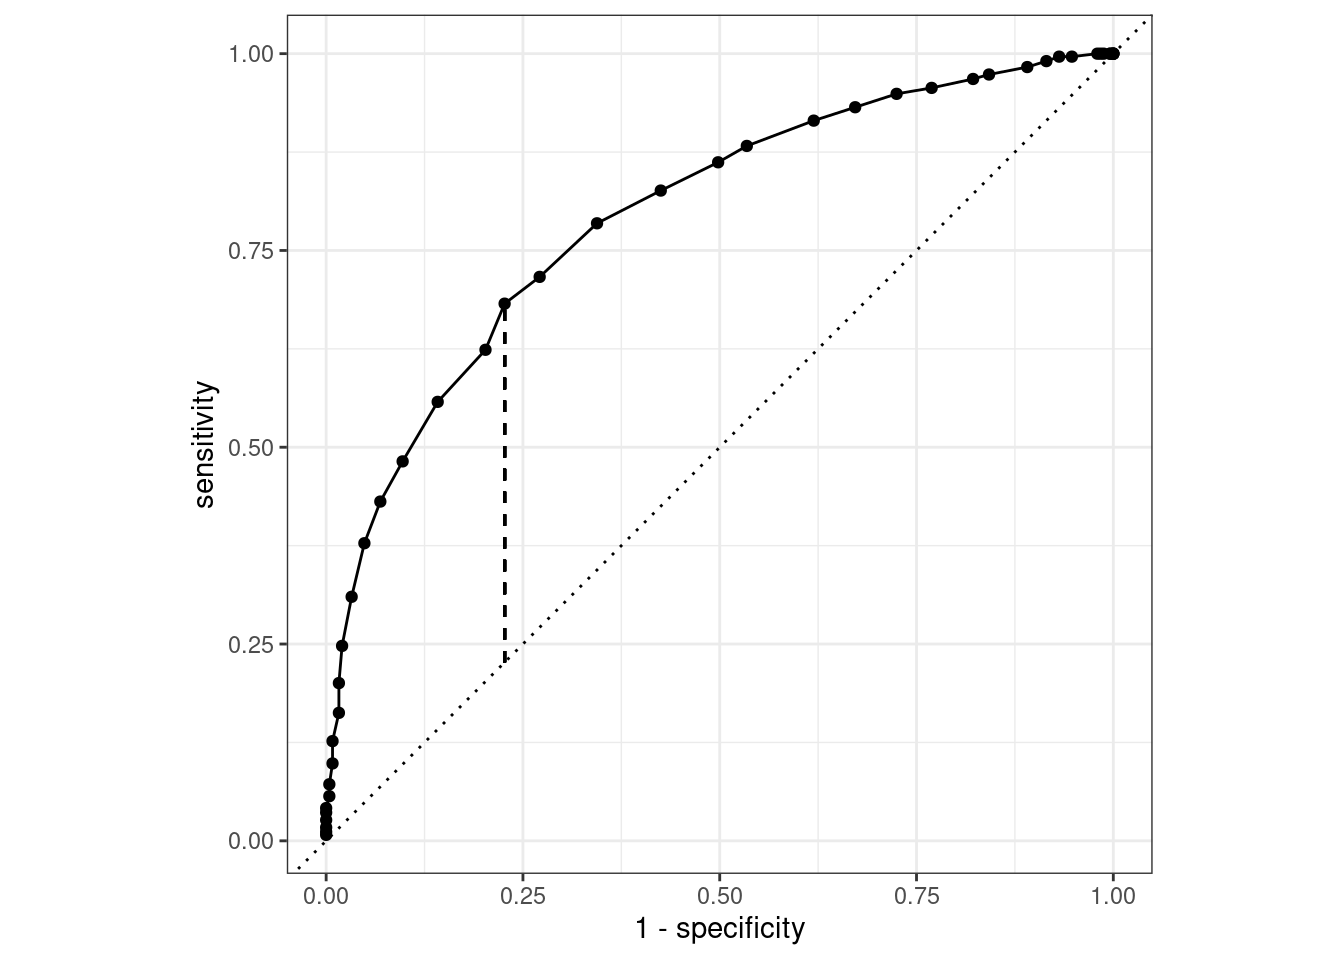

In [ ]:
library(probably)

In [ ]:
predictive_values_1_A |> knitr::kable()

  ------------------------------------------------------------------------------------------------
    .threshold         mcc   sensitivity   specificity         ppv         npv     j_index   score
  ------------ ----------- ------------- ------------- ----------- ----------- ----------- -------
     0.0315725          NA     1.0000000     0.0000000   0.6817010         NaN   0.0000000      -1

     0.0375899          NA     1.0000000     0.0000000   0.6817010         NaN   0.0000000       0

     0.0447012          NA     1.0000000     0.0000000   0.6817010         NaN   0.0000000       1

     0.0530836          NA     1.0000000     0.0000000   0.6817010         NaN   0.0000000       2

     0.0629343   0.0525689     1.0000000     0.0040486   0.6825806   1.0000000   0.0040486       3

     0.0744692   0.0525689     1.0000000     0.0040486   0.6825806   1.0000000   0.0040486       4

     0.0879200   0.0911696     1.0000000     0.0121457   0.6843467   1.0000000   0.0121457       5

     0.1035285   0.1053418     1.0000000     0.0161943   0.6852332   1.0000000   0.0161943       6

     0.1215388   0.1178521     1.0000000     0.0202429   0.6861219   1.0000000   0.0202429       7

     0.1421852   0.1652763     0.9962193     0.0526316   0.6925099   0.8666667   0.0488509       8

     0.1656775   0.1960500     0.9962193     0.0688259   0.6961691   0.8947368   0.0650452       9

     0.1921817   0.1956138     0.9905482     0.0850202   0.6986667   0.8076923   0.0755684      10

     0.2217987   0.2044108     0.9829868     0.1093117   0.7027027   0.7500000   0.0922985      11

     0.2545418   0.2426961     0.9735350     0.1578947   0.7123098   0.7358491   0.1314297      12

     0.2903153   0.2527062     0.9678639     0.1781377   0.7160839   0.7213115   0.1460015      13

     0.3288983   0.2869086     0.9565217     0.2307692   0.7270115   0.7125000   0.1872910      14

     0.3699360   0.3187135     0.9489603     0.2753036   0.7371512   0.7157895   0.2242639      15

     0.4129435   0.3383120     0.9319471     0.3279352   0.7481032   0.6923077   0.2598823      16

     0.4573217   0.3589696     0.9149338     0.3805668   0.7598116   0.6762590   0.2955006      17

     0.5023878   0.3867546     0.8827977     0.4655870   0.7796327   0.6497175   0.3483848      18

     0.5474152   0.3896178     0.8620038     0.5020243   0.7875648   0.6294416   0.3640281      19

     0.5916796   0.4070031     0.8260870     0.5748988   0.8062731   0.6068376   0.4009857      20

     0.6345054   0.4285031     0.7844991     0.6558704   0.8300000   0.5869565   0.4403695      21

     0.6753043   0.4194675     0.7164461     0.7287449   0.8497758   0.5454545   0.4451911      22

     0.7136046   0.4257348     0.6824197     0.7732794   0.8657074   0.5320334   0.4556990      23

     0.7490659   0.3926635     0.6238185     0.7975709   0.8684211   0.4974747   0.4213894      24

     0.7814810   0.3919213     0.5576560     0.8582996   0.8939394   0.4753363   0.4159555      25

     0.8107665   0.3736082     0.4820416     0.9028340   0.9139785   0.4486922   0.3848756      26

     0.8369462   0.3629658     0.4310019     0.9311741   0.9306122   0.4331450   0.3621760      27

     0.8601288   0.3444368     0.3780718     0.9514170   0.9433962   0.4166667   0.3294888      28

     0.8804861   0.3113583     0.3100189     0.9676113   0.9534884   0.3956954   0.2776302      29

     0.8982310   0.2786096     0.2476371     0.9797571   0.9632353   0.3781250   0.2273941      30

     0.9135998   0.2459768     0.2003781     0.9838057   0.9636364   0.3648649   0.1841837      31

     0.9268367   0.2129436     0.1625709     0.9838057   0.9555556   0.3542274   0.1463766      32

     0.9381829   0.1940300     0.1266541     0.9919028   0.9710145   0.3465347   0.1185569      33

     0.9478685   0.1651295     0.0982987     0.9919028   0.9629630   0.3393352   0.0902015      34

     0.9561075   0.1445254     0.0718336     0.9959514   0.9743590   0.3337856   0.0677851      35

     0.9630951   0.1252611     0.0567108     0.9959514   0.9677419   0.3302013   0.0526622      36

     0.9690063   0.1167203     0.0415879     1.0000000   1.0000000   0.3275862   0.0415879      37

     0.9739963   0.1082554     0.0359168     1.0000000   1.0000000   0.3262880   0.0359168      38

     0.9782010   0.0926205     0.0264650     1.0000000   1.0000000   0.3241470   0.0264650      39

     0.9817385   0.0740192     0.0170132     1.0000000   1.0000000   0.3220339   0.0170132      40

     0.9847110   0.0603186     0.0113422     1.0000000   1.0000000   0.3207792   0.0113422      41

     0.9872059   0.0491861     0.0075614     1.0000000   1.0000000   0.3199482   0.0075614      42
  ------------------------------------------------------------------------------------------------


  risk_factor         min_range   max_range   points
  ----------------- ----------- ----------- --------
  LZD_duration_14             0           0        0
  LZD_duration_14             1           1        5
  comed_heparin               0           0        0
  comed_heparin               1           1        5
  infect_sepsis               0           0        0
  infect_sepsis               1           1        3
  baseline_CLCR             130         Inf       -1
  baseline_CLCR              90         130        0
  baseline_CLCR              60          90        1
  baseline_CLCR              30          60        2
  baseline_CLCR            -Inf          30        3
  comorb_cirr                 0           0        0
  comorb_cirr                 1           1        5
  invasive_CRRT               0           0        0
  invasive_CRRT               1           1        2
  baseline_PLT              150         Inf        0
  baseline_PLT               75         150        8
  baseline_PLT               50          75       10
  baseline_PLT               25          50       11
  baseline_PLT             -Inf          25       12
  patient_age                18          30        0
  patient_age                30          40        1
  patient_age                40          50        2
  patient_age                50          60        3
  patient_age                60          70        4
  patient_age                70          80        5
  patient_age                80          90        6
  patient_age                90         101        7


    points_total   risk_estimate
  -------------- ---------------
              -1       0.0315725
               0       0.0375899
               1       0.0447012
               2       0.0530836
               3       0.0629343
               4       0.0744692
               5       0.0879200
               6       0.1035285
               7       0.1215388
               8       0.1421852
               9       0.1656775
              10       0.1921817
              11       0.2217987
              12       0.2545418
              13       0.2903153
              14       0.3288983
              15       0.3699360
              16       0.4129435
              17       0.4573217
              18       0.5023878
              19       0.5474152
              20       0.5916796
              21       0.6345054
              22       0.6753043
              23       0.7136046
              24       0.7490659
              25       0.7814810
              26       0.8107665
              27       0.8369462
              28       0.8601288
              29       0.8804861
              30       0.8982310
              31       0.9135998
              32       0.9268367
              33       0.9381829
              34       0.9478685
              35       0.9561075
              36       0.9630951
              37       0.9690063
              38       0.9739963
              39       0.9782010
              40       0.9817385
              41       0.9847110
              42       0.9872059


# BMA Black Box (10 variables)

In [ ]:
library(BAS)
model_black_box_estimates <- coef(model_black_box) |>
  confint(nsim = 2^20) |>
  structure(class = c("confint.bas", "matrix")) |>
  as_tibble() |>
  mutate(
    term = model_black_box$namesx |>
      str_extract(paste(c(variables_to_screen_short, "Intercept"), collapse = "|")) |>
      unique()
  ) |>
  relocate(c(term, beta)) |>
  rename(
    risk_factor = term,
    lower = `2.5%`,
    upper = `97.5%`
  ) |>
  mutate(across(c(lower, upper, beta), as.double))

model_black_box_odds_ratio <- model_black_box_estimates |>
  mutate(across(c(lower, upper, beta), exp)) |>
  rename(
    odds_ratio = beta
  )

In [ ]:
risk_profile_BMA_1 <- tibble(
  risk_factor = "patient_age",
  min_range = c(18, 30, 40, 50, 60, 70, 80, 90), # minimum age is 18
  max_range = lead(min_range, default = 101), # maximum age is 101, interval is 10
  reference = (min_range + max_range) / 2,
  flag_base_risk = FALSE
) |>
  mutate(
    flag_base_risk = replace(flag_base_risk, 1, TRUE)
  )

risk_profile_BMA_2 <- tibble(
  risk_factor = "baseline_CLCR",
  min_range = c(130, 90, 60, 30, 5), # 1% percentile is 5
  max_range = lag(min_range, default = 191), # 99% percentile is 191
  reference = (min_range + max_range) / 2,
  flag_base_risk = FALSE
) |>
  mutate(
    min_range = replace(min_range, n(), -Inf),
    max_range = replace(max_range, 1, Inf),
    flag_base_risk = ifelse(min_range == 90, TRUE, flag_base_risk)
  )

risk_profile_BMA_3 <- tibble(
  risk_factor = "baseline_PLT",
  min_range = c(150, 75, 50, 25, 18), # 1% percentile is 18
  max_range = lag(min_range, default = 434), # 99% percentile is 434
  reference = (min_range + max_range) / 2,
  flag_base_risk = FALSE
) |>
  mutate(
    min_range = replace(min_range, n(), -Inf),
    max_range = replace(max_range, 1, Inf),
    flag_base_risk = replace(flag_base_risk, 1, TRUE)
  )

risk_profile_BMA_4 <- tibble(
  risk_factor = "LZD_duration_14",
  min_range = c(0, 1), # 0 or 1
  max_range = c(0, 1), # 0 or 1
  reference = c(0, 1),
  flag_base_risk = FALSE
) |>
  mutate(
    flag_base_risk = replace(flag_base_risk, 1, TRUE)
  )

risk_profile_BMA_5 <- tibble(
  risk_factor = "comed_heparin",
  min_range = c(0, 1), # 0 or 1
  max_range = c(0, 1), # 0 or 1
  reference = c(0, 1),
  flag_base_risk = FALSE
) |>
  mutate(
    flag_base_risk = replace(flag_base_risk, 1, TRUE)
  )

risk_profile_BMA_6 <- tibble(
  risk_factor = "infect_sepsis",
  min_range = c(0, 1), # 0 or 1
  max_range = c(0, 1), # 0 or 1
  reference = c(0, 1),
  flag_base_risk = FALSE
) |>
  mutate(
    flag_base_risk = replace(flag_base_risk, 1, TRUE)
  )

risk_profile_BMA_7 <- tibble(
  risk_factor = "dept_ICU_ER",
  min_range = c(0, 1), # 0 or 1
  max_range = c(0, 1), # 0 or 1
  reference = c(0, 1),
  flag_base_risk = FALSE
) |>
  mutate(
    flag_base_risk = replace(flag_base_risk, 1, TRUE)
  )

risk_profile_BMA_8 <- tibble(
  risk_factor = "comorb_cirr",
  min_range = c(0, 1), # 0 or 1
  max_range = c(0, 1), # 0 or 1
  reference = c(0, 1),
  flag_base_risk = FALSE
) |>
  mutate(
    flag_base_risk = replace(flag_base_risk, 1, TRUE)
  )

risk_profile_BMA_9 <- tibble(
  risk_factor = "invasive_CRRT",
  min_range = c(0, 1), # 0 or 1
  max_range = c(0, 1), # 0 or 1
  reference = c(0, 1),
  flag_base_risk = FALSE
) |>
  mutate(
    flag_base_risk = replace(flag_base_risk, 1, TRUE)
  )

risk_profile_BMA_10 <- tibble(
  risk_factor = "comed_enoxaparin",
  min_range = c(0, 1), # 0 or 1
  max_range = c(0, 1), # 0 or 1
  reference = c(0, 1),
  flag_base_risk = FALSE
) |>
  mutate(
    flag_base_risk = replace(flag_base_risk, 1, TRUE)
  )

# risk_profile_BMA_11 <- tibble(
#   risk_factor = "LZD_route_IV",
#   min_range = c(0, 1), # 0 or 1
#   max_range = c(0, 1), # 0 or 1
#   reference = c(0, 1),
#   flag_base_risk = FALSE
# ) |>
#   mutate(
#     flag_base_risk = replace(flag_base_risk, 1, TRUE)
#   )

# risk_profile_BMA_12 <- tibble(
#   risk_factor = "infect_septicemia",
#   min_range = c(0, 1), # 0 or 1
#   max_range = c(0, 1), # 0 or 1
#   reference = c(0, 1),
#   flag_base_risk = FALSE
# ) |>
#   mutate(
#     flag_base_risk = replace(flag_base_risk, 1, TRUE)
#   )

# risk_profile_BMA_13 <- tibble(
#   risk_factor = "invasive_IHD",
#   min_range = c(0, 1), # 0 or 1
#   max_range = c(0, 1), # 0 or 1
#   reference = c(0, 1),
#   flag_base_risk = FALSE
# ) |>
#   mutate(
#     flag_base_risk = replace(flag_base_risk, 1, TRUE)
#   )

risk_profile_BMA <- paste0("risk_profile_BMA_", 1:10) |>
  mget() |> # "when you have to use mget(), something has gone wrong"
  bind_rows()

In [ ]:
points_system_BMA <- create_point_system(model_black_box_estimates, risk_profile_BMA)
points_system_factors_BMA <- points_system_BMA$points_system_factors
points_system_risks_BMA <- points_system_BMA$points_system_risks
points_system_full_BMA <- points_system_BMA$points_system_full

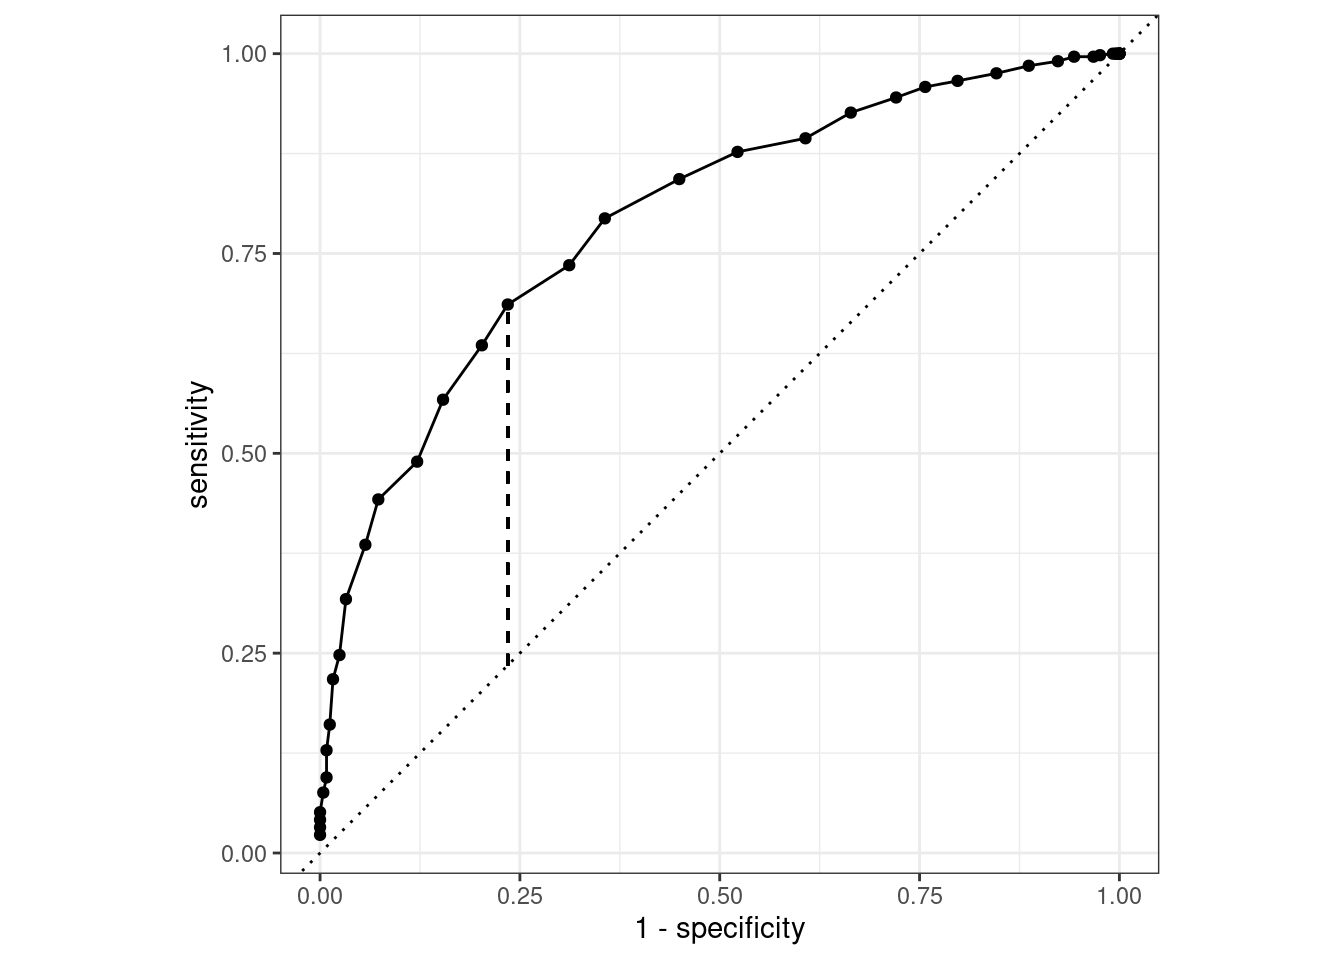

In [ ]:
library(probably)

BMA_pred <- predict(model_black_box, type = "response")

predictive_values_BMA <- BMA_pred$fit |>
  as_tibble() |>
  rename(.pred_TRUE = value) |>
  mutate(
    .pred_FALSE = 1 - .pred_TRUE,
    flag_ADR_TP_ID = data_patient_transformed$flag_ADR_TP_ID |> as_factor()
  ) |>
  threshold_perf(
    truth = flag_ADR_TP_ID,
    estimate = .pred_FALSE,
    thresholds = points_system_risks_BMA |> pull(risk_estimate),
    metrics = metric_set(mcc, sensitivity, specificity, ppv, npv, j_index)
  ) |>
  select(-.estimator) |>
  pivot_wider(names_from = .metric, values_from = .estimate) |>
  mutate(score = points_system_risks_BMA |> pull(points_total))

predictive_values_BMA |>
  select(.threshold, sensitivity, specificity) |>
  ggplot(aes(x = 1 - specificity, y = sensitivity)) +
  geom_point() +
  geom_path() +
  geom_segment(
    x = 1 - (predictive_values_BMA |> filter(j_index == max(j_index)) |> pull(specificity)),
    xend = 1 - (predictive_values_BMA |> filter(j_index == max(j_index)) |> pull(specificity)),
    y = 1 - (predictive_values_BMA |> filter(j_index == max(j_index)) |> pull(specificity)),
    yend = predictive_values_BMA |> filter(j_index == max(j_index)) |> pull(sensitivity),
    linetype = 2
  ) +
  geom_abline(lty = 3) +
  coord_equal() +
  theme_bw()

In [ ]:
predictive_values_BMA |> knitr::kable()

  ------------------------------------------------------------------------------------------------
    .threshold         mcc   sensitivity   specificity         ppv         npv     j_index   score
  ------------ ----------- ------------- ------------- ----------- ----------- ----------- -------
     0.0335359          NA     1.0000000     0.0000000   0.6817010         NaN   0.0000000      -1

     0.0399907          NA     1.0000000     0.0000000   0.6817010         NaN   0.0000000       0

     0.0476268          NA     1.0000000     0.0000000   0.6817010         NaN   0.0000000       1

     0.0566348          NA     1.0000000     0.0000000   0.6817010         NaN   0.0000000       2

     0.0672263          NA     1.0000000     0.0000000   0.6817010         NaN   0.0000000       3

     0.0796315   0.0525689     1.0000000     0.0040486   0.6825806   1.0000000   0.0040486       4

     0.0940948   0.0525689     1.0000000     0.0040486   0.6825806   1.0000000   0.0040486       5

     0.1108686   0.0743916     1.0000000     0.0080972   0.6834625   1.0000000   0.0080972       6

     0.1302028   0.1103657     0.9981096     0.0242915   0.6866060   0.8571429   0.0224011       7

     0.1523310   0.1181540     0.9962193     0.0323887   0.6879896   0.8000000   0.0286079       8

     0.1774527   0.1734046     0.9962193     0.0566802   0.6934211   0.8750000   0.0528994       9

     0.2057119   0.1815435     0.9905482     0.0769231   0.6968085   0.7916667   0.0674713      10

     0.2371738   0.2175636     0.9848771     0.1133603   0.7040541   0.7777778   0.0982375      11

     0.2718009   0.2430105     0.9754253     0.1538462   0.7117241   0.7450980   0.1292715      12

     0.3094328   0.2774305     0.9659735     0.2024291   0.7217514   0.7352941   0.1684027      13

     0.3497724   0.3050646     0.9584121     0.2429150   0.7305476   0.7317073   0.2013271      14

     0.3923828   0.3148664     0.9451796     0.2793522   0.7374631   0.7040816   0.2245318      15

     0.4366979   0.3356755     0.9262760     0.3360324   0.7492355   0.6803279   0.2623084      16

     0.4820472   0.3358498     0.8941399     0.3927126   0.7592295   0.6339869   0.2868524      17

     0.5276942   0.3893855     0.8771267     0.4777328   0.7824621   0.6448087   0.3548594      18

     0.5728829   0.4074744     0.8431002     0.5506073   0.8007181   0.6210046   0.3937075      19

     0.6168869   0.4287749     0.7939509     0.6437247   0.8267717   0.5932836   0.4376755      20

     0.6590555   0.4028724     0.7353497     0.6882591   0.8347639   0.5483871   0.4236088      21

     0.6988485   0.4220519     0.6862004     0.7651822   0.8622328   0.5323944   0.4513826      22

     0.7358585   0.4031521     0.6351607     0.7975709   0.8704663   0.5051282   0.4327315      23

     0.7698183   0.3882451     0.5671078     0.8461538   0.8875740   0.4771689   0.4132616      24

     0.8005951   0.3547174     0.4896030     0.8785425   0.8961938   0.4455852   0.3681455      25

     0.8281754   0.3675268     0.4423440     0.9271255   0.9285714   0.4370229   0.3694696      26

     0.8526431   0.3409298     0.3856333     0.9433198   0.9357798   0.4175627   0.3289531      27

     0.8741560   0.3172351     0.3175803     0.9676113   0.9545455   0.3983333   0.2851917      28

     0.8929226   0.2728619     0.2476371     0.9757085   0.9562044   0.3771518   0.2233456      29

     0.9091814   0.2601007     0.2173913     0.9838057   0.9663866   0.3698630   0.2011970      30

     0.9231838   0.2182071     0.1606805     0.9878543   0.9659091   0.3546512   0.1485348      31

     0.9351813   0.1958492     0.1285444     0.9919028   0.9714286   0.3470255   0.1204473      32

     0.9454157   0.1609992     0.0945180     0.9919028   0.9615385   0.3383978   0.0864208      33

     0.9541135   0.1490205     0.0756144     0.9959514   0.9756098   0.3346939   0.0715658      34

     0.9614817   0.1297363     0.0510397     1.0000000   1.0000000   0.3297730   0.0510397      35

     0.9677069   0.1167203     0.0415879     1.0000000   1.0000000   0.3275862   0.0415879      36

     0.9729543   0.1022643     0.0321361     1.0000000   1.0000000   0.3254282   0.0321361      37

     0.9773689   0.0856376     0.0226843     1.0000000   1.0000000   0.3232984   0.0226843      38
  ------------------------------------------------------------------------------------------------


  risk_factor          min_range   max_range   points
  ------------------ ----------- ----------- --------
  LZD_duration_14              0           0        0
  LZD_duration_14              1           1        5
  comed_heparin                0           0        0
  comed_heparin                1           1        5
  comed_enoxaparin             0           0        0
  comed_enoxaparin             1           1        0
  infect_sepsis                0           0        0
  infect_sepsis                1           1        3
  baseline_CLCR              130         Inf       -1
  baseline_CLCR               90         130        0
  baseline_CLCR               60          90        1
  baseline_CLCR               30          60        1
  baseline_CLCR             -Inf          30        2
  comorb_cirr                  0           0        0
  comorb_cirr                  1           1        3
  invasive_CRRT                0           0        0
  invasive_CRRT                1           1        1
  dept_ICU_ER                  0           0        0
  dept_ICU_ER                  1           1        0
  baseline_PLT               150         Inf        0
  baseline_PLT                75         150        8
  baseline_PLT                50          75       10
  baseline_PLT                25          50       12
  baseline_PLT              -Inf          25       12
  patient_age                 18          30        0
  patient_age                 30          40        1
  patient_age                 40          50        2
  patient_age                 50          60        3
  patient_age                 60          70        4
  patient_age                 70          80        5
  patient_age                 80          90        6
  patient_age                 90         101        7


    points_total   risk_estimate
  -------------- ---------------
              -1       0.0335359
               0       0.0399907
               1       0.0476268
               2       0.0566348
               3       0.0672263
               4       0.0796315
               5       0.0940948
               6       0.1108686
               7       0.1302028
               8       0.1523310
               9       0.1774527
              10       0.2057119
              11       0.2371738
              12       0.2718009
              13       0.3094328
              14       0.3497724
              15       0.3923828
              16       0.4366979
              17       0.4820472
              18       0.5276942
              19       0.5728829
              20       0.6168869
              21       0.6590555
              22       0.6988485
              23       0.7358585
              24       0.7698183
              25       0.8005951
              26       0.8281754
              27       0.8526431
              28       0.8741560
              29       0.8929226
              30       0.9091814
              31       0.9231838
              32       0.9351813
              33       0.9454157
              34       0.9541135
              35       0.9614817
              36       0.9677069
              37       0.9729543
              38       0.9773689


# Logistic Model 2-A

In [ ]:
library(tidyverse)
library(tidymodels)

model_beta_estimates_2_A <- model_full_BPM_2_A |>
  tidy() |>
  select(term, estimate, p.value)

model_odds_ratios_2_A <- model_full_BPM_2_A |>
  tidy(conf.int = TRUE, exponentiate = TRUE) |>
  select(term, estimate, conf.low, conf.high) |>
  filter(term != "(Intercept)") |>
  rename(odds_ratio = estimate, OR_lower = conf.low, OR_upper = conf.high)

predictor_list_with_intercept_2_A <- c(variables_to_screen, "(Intercept)")

parameter_estimates_2_A <- 
  left_join(model_beta_estimates_2_A, model_odds_ratios_2_A, by = "term") |>
  rename(risk_factor = term, beta = estimate, p_value = p.value) |>
  mutate(risk_factor = str_extract(risk_factor, paste(predictor_list_with_intercept_2_A, collapse = "|")))

# parameter_estimates |>
#   mutate(raw_score = beta / min(abs(beta)))

In [ ]:
data_refit_2_A <- model_full_BPM_2_A |>
  extract_mold() |>
  _$predictors |>
  mutate(across(where(is.numeric), ~ . / 10)) |>
  rename_with(~ paste0(., "_per_10"), .cols = where(is.numeric)) |>
  bind_cols(model_full_BPM_2_A |> extract_mold() |> _$outcomes)

model_refit_2_A <- workflow() |>
  add_variables(outcomes = "flag_ADR_TP_ID", predictors = everything()) |>
  add_model(logistic_reg()) |>
  fit(data = data_refit_2_A)

model_refit_odds_ratios_2_A <- model_refit_2_A |>
  tidy(conf.int = TRUE, exponentiate = TRUE) |>
  select(term, estimate, conf.low, conf.high) |>
  filter(term != "(Intercept)") |>
  rename(odds_ratio = estimate, OR_lower = conf.low, OR_upper = conf.high) |>
  mutate(term = str_replace_all(term, "TRUE", ""))

All code below is not automatic. Variables and ranges are manually defined.

Current model predictors: `patient_age`, `baseline_PLT`, `LZD_duration_14`, `comed_heparin`, `infect_sepsis`

In [ ]:
risk_profile_2_A_1 <- tibble(
  risk_factor = "patient_age",
  min_range = c(18, 30, 40, 50, 60, 70, 80, 90), # minimum age is 18
  max_range = lead(min_range, default = 101), # maximum age is 101, interval is 10
  reference = (min_range + max_range) / 2,
  flag_base_risk = FALSE
) |>
  mutate(
    flag_base_risk = replace(flag_base_risk, 1, TRUE)
  )

# risk_profile_2_A_2 <- tibble(
#   risk_factor = "baseline_CLCR",
#   min_range = c(130, 90, 60, 30, 5), # 1% percentile is 5
#   max_range = lag(min_range, default = 191), # 99% percentile is 191
#   reference = (min_range + max_range) / 2,
#   flag_base_risk = FALSE
# ) |>
#   mutate(
#     min_range = replace(min_range, n(), -Inf),
#     max_range = replace(max_range, 1, Inf),
#     flag_base_risk = ifelse(min_range == 90, TRUE, flag_base_risk)
#   )

risk_profile_2_A_3 <- tibble(
  risk_factor = "baseline_PLT",
  min_range = c(150, 75, 50, 25, 18), # 1% percentile is 18
  max_range = lag(min_range, default = 434), # 99% percentile is 434
  reference = (min_range + max_range) / 2,
  flag_base_risk = FALSE
) |>
  mutate(
    min_range = replace(min_range, n(), -Inf),
    max_range = replace(max_range, 1, Inf),
    flag_base_risk = replace(flag_base_risk, 1, TRUE)
  )

risk_profile_2_A_4 <- tibble(
  risk_factor = "LZD_duration_14",
  min_range = c(0, 1), # 0 or 1
  max_range = c(0, 1), # 0 or 1
  reference = c(0, 1),
  flag_base_risk = FALSE
) |>
  mutate(
    flag_base_risk = replace(flag_base_risk, 1, TRUE)
  )

risk_profile_2_A_5 <- tibble(
  risk_factor = "comed_heparin",
  min_range = c(0, 1), # 0 or 1
  max_range = c(0, 1), # 0 or 1
  reference = c(0, 1),
  flag_base_risk = FALSE
) |>
  mutate(
    flag_base_risk = replace(flag_base_risk, 1, TRUE)
  )

risk_profile_2_A_6 <- tibble(
  risk_factor = "infect_sepsis",
  min_range = c(0, 1), # 0 or 1
  max_range = c(0, 1), # 0 or 1
  reference = c(0, 1),
  flag_base_risk = FALSE
) |>
  mutate(
    flag_base_risk = replace(flag_base_risk, 1, TRUE)
  )

# risk_profile_2_A_7 <- tibble(
#   risk_factor = "comorb_cirr",
#   min_range = c(0, 1), # 0 or 1
#   max_range = c(0, 1), # 0 or 1
#   reference = c(0, 1),
#   flag_base_risk = FALSE
# ) |>
#   mutate(
#     flag_base_risk = replace(flag_base_risk, 1, TRUE)
#   )

# risk_profile_2_A_8 <- tibble(
#   risk_factor = "invasive_CRRT",
#   min_range = c(0, 1), # 0 or 1
#   max_range = c(0, 1), # 0 or 1
#   reference = c(0, 1),
#   flag_base_risk = FALSE
# ) |>
#   mutate(
#     flag_base_risk = replace(flag_base_risk, 1, TRUE)
#   )

risk_profile_2_A <- bind_rows(risk_profile_2_A_1, risk_profile_2_A_3, risk_profile_2_A_4, risk_profile_2_A_5, risk_profile_2_A_6)

In [ ]:
create_point_system <- function(parameter_estimates, risk_profile) {
  B_constant <- parameter_estimates |>
    filter(risk_factor == "patient_age") |>
    pull(beta) * 10 # constant equivalent to 10-year increase in age

  points_system_full <- parameter_estimates |>
    select(risk_factor, beta) |>
    right_join(risk_profile, by = "risk_factor") |>
    group_by(risk_factor) |>
    mutate(
      beta_sum = beta * (reference - reference[which.max(flag_base_risk)]),
      points = round(beta_sum / B_constant, 0)
    )

  points_system_factors <- points_system_full |>
    select(risk_factor, min_range, max_range, points)

  min_points <- points_system_full |>
    group_by(risk_factor) |>
    summarise(min_points = min(points)) |>
    summarise(total_min_points = sum(min_points)) |>
    pull(total_min_points)

  max_points <- points_system_full |>
    group_by(risk_factor) |>
    summarise(max_points = max(points)) |>
    summarise(total_max_points = sum(max_points)) |>
    pull(total_max_points)

  risk_function <- function(points) {
    intercept <- parameter_estimates |>
      filter(risk_factor == "Intercept") |>
      pull(beta)

    beta_base <- points_system_full |>
      filter(flag_base_risk == TRUE) |>
      ungroup() |>
      summarise(
        beta_base = sum(beta * reference)
      ) |>
      pull(beta_base)

    1 / (1 + exp(-(intercept + beta_base + B_constant * points)))
  }

  points_system_risks <- tibble(
    points_total = seq(min_points, max_points),
    risk_estimate = risk_function(points_total)
  )
  list(points_system_full = points_system_full, points_system_factors = points_system_factors, points_system_risks = points_system_risks)
}

points_system_2_A <- create_point_system(parameter_estimates_2_A, risk_profile_2_A)
points_system_full_2_A <- points_system_2_A$points_system_full
points_system_factors_2_A <- points_system_2_A$points_system_factors
points_system_risks_2_A <- points_system_2_A$points_system_risks

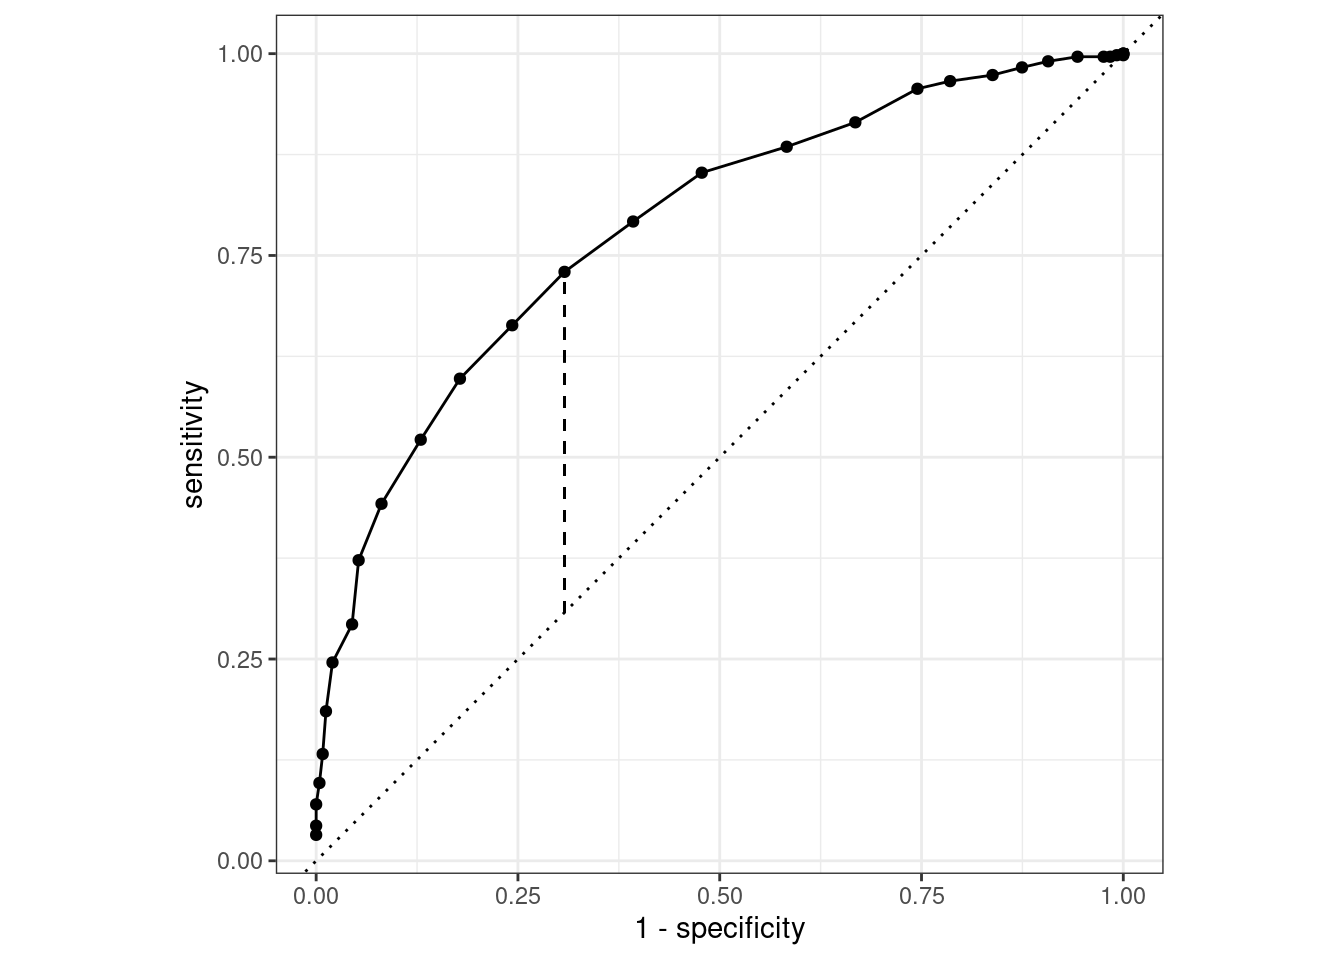

In [ ]:
library(probably)
predictive_values_2_A <- model_refit_2_A |>
  predict(data_refit_2_A, type = "prob") |>
  mutate(flag_ADR_TP_ID = data_refit_2_A$flag_ADR_TP_ID) |>
  threshold_perf(
    truth = flag_ADR_TP_ID,
    estimate = .pred_FALSE,
    thresholds = points_system_risks_2_A |> pull(risk_estimate),
    metrics = metric_set(mcc, sensitivity, specificity, ppv, npv, j_index)
  ) |>
  select(-.estimator) |>
  pivot_wider(names_from = .metric, values_from = .estimate) |>
  mutate(score = points_system_risks_2_A |> pull(points_total))

predictive_values_2_A |>
  select(.threshold, sensitivity, specificity) |>
  ggplot(aes(x = 1 - specificity, y = sensitivity)) +
  geom_point() +
  geom_path() +
  geom_segment(
    x = 1 - (predictive_values_2_A |> filter(j_index == max(j_index)) |> pull(specificity)),
    xend = 1 - (predictive_values_2_A |> filter(j_index == max(j_index)) |> pull(specificity)),
    y = 1 - (predictive_values_2_A |> filter(j_index == max(j_index)) |> pull(specificity)),
    yend = predictive_values_2_A |> filter(j_index == max(j_index)) |> pull(sensitivity),
    linetype = 2
  ) +
  geom_abline(lty = 3) +
  coord_equal() +
  theme_bw()

In [ ]:
predictive_values_2_A |> knitr::kable()

  --------------------------------------------------------------------------------------------------
    .threshold          mcc   sensitivity   specificity         ppv         npv      j_index   score
  ------------ ------------ ------------- ------------- ----------- ----------- ------------ -------
     0.0433021           NA     1.0000000     0.0000000   0.6817010         NaN    0.0000000       0

     0.0534303           NA     1.0000000     0.0000000   0.6817010         NaN    0.0000000       1

     0.0657646           NA     1.0000000     0.0000000   0.6817010         NaN    0.0000000       2

     0.0807036   -0.0245454     0.9981096     0.0000000   0.6812903   0.0000000   -0.0018904       3

     0.0986776    0.0465902     0.9981096     0.0080972   0.6830530   0.6666667    0.0062068       4

     0.1201315    0.0660167     0.9962193     0.0161943   0.6844156   0.6666667    0.0124136       5

     0.1454970    0.0945873     0.9962193     0.0242915   0.6861979   0.7500000    0.0205108       6

     0.1751521    0.1734046     0.9962193     0.0566802   0.6934211   0.8750000    0.0528994       7

     0.2093705    0.2089746     0.9905482     0.0931174   0.7005348   0.8214286    0.0836656       8

     0.2482619    0.2285643     0.9829868     0.1255061   0.7065217   0.7750000    0.1084928       9

     0.2917121    0.2480165     0.9735350     0.1619433   0.7132964   0.7407407    0.1354783      10

     0.3393341    0.2917066     0.9659735     0.2145749   0.7248227   0.7464789    0.1805484      11

     0.3904449    0.3139657     0.9565217     0.2550607   0.7333333   0.7325581    0.2115825      12

     0.4440794    0.3108882     0.9149338     0.3319838   0.7457627   0.6456693    0.2469176      13

     0.4990496    0.3442252     0.8846881     0.4170040   0.7647059   0.6280488    0.3016921      14

     0.5540427    0.3947815     0.8525520     0.5222672   0.7926186   0.6231884    0.3748192      15

     0.6077440    0.3941089     0.7920605     0.6072874   0.8120155   0.5769231    0.3993479      16

     0.6589592    0.4004874     0.7296786     0.6923077   0.8354978   0.5445860    0.4219863      17

     0.7067144    0.3925359     0.6635161     0.7570850   0.8540146   0.5123288    0.4206011      18

     0.7503163    0.3915760     0.5973535     0.8218623   0.8777778   0.4879808    0.4192158      19

     0.7893681    0.3733949     0.5217391     0.8704453   0.8961039   0.4594017    0.3921845      20

     0.8237467    0.3587395     0.4423440     0.9190283   0.9212598   0.4348659    0.3613724      21

     0.8535552    0.3352703     0.3724008     0.9473684   0.9380952   0.4134276    0.3197692      22

     0.8790625    0.2822497     0.2930057     0.9554656   0.9337349   0.3868852    0.2484713      23

     0.9006441    0.2770985     0.2457467     0.9797571   0.9629630   0.3775351    0.2255038      24

     0.9187305    0.2396539     0.1852552     0.9878543   0.9702970   0.3614815    0.1731094      25

     0.9337667    0.1994542     0.1323251     0.9919028   0.9722222   0.3480114    0.1242280      26

     0.9461838    0.1720632     0.0964083     0.9959514   0.9807692   0.3397790    0.0923597      27

     0.9563818    0.1528971     0.0699433     1.0000000   1.0000000   0.3342355    0.0699433      28

     0.9647194    0.1194228     0.0434783     1.0000000   1.0000000   0.3280212    0.0434783      29

     0.9715107    0.1022643     0.0321361     1.0000000   1.0000000   0.3254282    0.0321361      30
  --------------------------------------------------------------------------------------------------


  risk_factor         min_range   max_range   points
  ----------------- ----------- ----------- --------
  LZD_duration_14             0           0        0
  LZD_duration_14             1           1        4
  comed_heparin               0           0        0
  comed_heparin               1           1        5
  infect_sepsis               0           0        0
  infect_sepsis               1           1        3
  baseline_PLT              150         Inf        0
  baseline_PLT               75         150        7
  baseline_PLT               50          75        9
  baseline_PLT               25          50       10
  baseline_PLT             -Inf          25       11
  patient_age                18          30        0
  patient_age                30          40        1
  patient_age                40          50        2
  patient_age                50          60        3
  patient_age                60          70        4
  patient_age                70          80        5
  patient_age                80          90        6
  patient_age                90         101        7


    points_total   risk_estimate
  -------------- ---------------
               0       0.0433021
               1       0.0534303
               2       0.0657646
               3       0.0807036
               4       0.0986776
               5       0.1201315
               6       0.1454970
               7       0.1751521
               8       0.2093705
               9       0.2482619
              10       0.2917121
              11       0.3393341
              12       0.3904449
              13       0.4440794
              14       0.4990496
              15       0.5540427
              16       0.6077440
              17       0.6589592
              18       0.7067144
              19       0.7503163
              20       0.7893681
              21       0.8237467
              22       0.8535552
              23       0.8790625
              24       0.9006441
              25       0.9187305
              26       0.9337667
              27       0.9461838
              28       0.9563818
              29       0.9647194
              30       0.9715107
